# Supervised Machine Learning: Regression

* price: price in US dollars (\$326–\$18,823)
* carat: weight of the diamond (0.2–5.01)
* cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* color: diamond colour, from D (best) to J (worst)
* clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* x: length in mm (0–10.74)
* y: width in mm (0–58.9)
* z: depth in mm (0–31.8)
* depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43–79)
* table: width of top of diamond relative to widest point (43–95)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

diamonds = sns.load_dataset('diamonds')

from sklearn.model_selection import train_test_split
X = diamonds.drop(columns=['price'])
y = diamonds['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
34530,0.33,Ideal,G,VVS1,62.0,56.0,4.45,4.48,2.77
26173,2.00,Very Good,I,VS2,59.5,62.0,8.13,8.21,4.86
20038,0.30,Good,H,SI1,63.4,58.0,4.21,4.24,2.68
41661,0.54,Ideal,J,VVS1,62.2,54.0,5.23,5.25,3.26
42306,0.41,Premium,D,VVS2,62.5,58.0,4.72,4.75,2.96


## 1st iteration: dummy model and linear regression + regression errors

### Dummy model

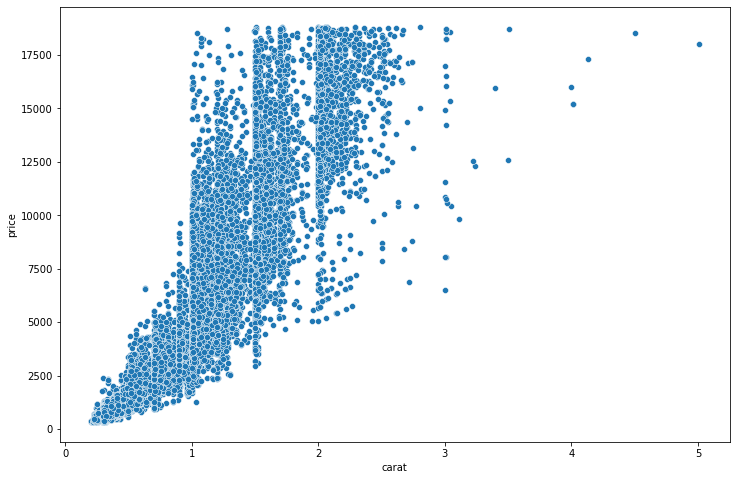

In [3]:
plt.subplots(figsize=(12, 8))
sns.scatterplot(x=X_train['carat'], y=y_train)
plt.show()

Based on the graph below I am going to create a real simple model:

$$
price = carat*4000
$$

In [4]:
def my_dummy_model(carat): 
    return carat * 4000

dummy_model_res = (
X_train
    .assign(
        preds = lambda x: my_dummy_model(x['carat']), 
        price = y_train
        )
    .assign(
        error = lambda x:  x['preds'] - x['price']
    )
)
dummy_model_res

,carat,cut,color,clarity,depth,table,x,y,z,preds,price,error
34530,0.33,Ideal,G,VVS1,62.0,56.0,4.45,4.48,2.77,1320.0,868,452.0
26173,2.00,Very Good,I,VS2,59.5,62.0,8.13,8.21,4.86,8000.0,15510,-7510.0
20038,0.30,Good,H,SI1,63.4,58.0,4.21,4.24,2.68,1200.0,421,779.0
41661,0.54,Ideal,J,VVS1,62.2,54.0,5.23,5.25,3.26,2160.0,1239,921.0
42306,0.41,Premium,D,VVS2,62.5,58.0,4.72,4.75,2.96,1640.0,1295,345.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10376,1.20,Premium,J,SI1,58.5,61.0,6.95,6.89,4.05,4800.0,4778,22.0
34949,0.31,Ideal,I,SI2,61.0,56.0,4.39,4.43,2.69,1240.0,379,861.0
18417,1.24,Premium,D,SI1,62.4,59.0,6.86,6.82,4.27,4960.0,7486,-2526.0
25940,2.01,Premium,G,SI1,61.8,59.0,8.15,8.09,5.02,8040.0,15105,-7065.0


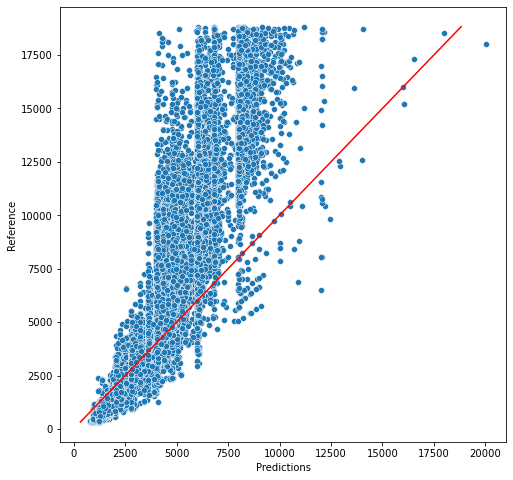

In [5]:
def plot_predictions(y_true, y_pred): 
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = min([min(y_pred.tolist()), min(y_true.tolist())])
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.show()
plot_predictions(dummy_model_res['price'], dummy_model_res['preds'])

### Creating our first Linear Model

In [6]:
np.array(X_train['carat']).reshape(-1, 1)

array([[0.33],
       [2.  ],
       [0.3 ],
       ...,
       [1.24],
       [2.01],
       [0.82]])

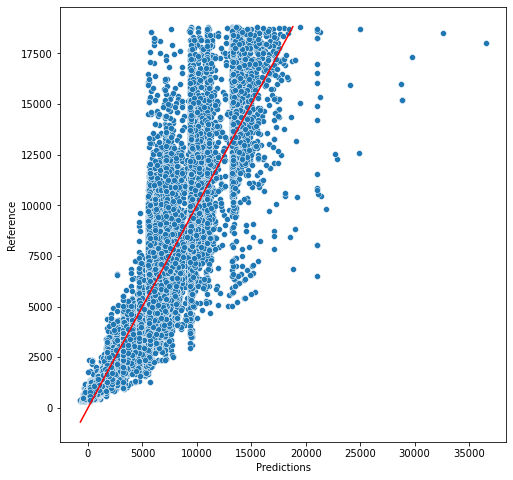

In [7]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(np.array(X_train['carat']).reshape(-1, 1), y_train)
plot_predictions(y_train, lm.predict(np.array(X_train['carat']).reshape(-1, 1)))

In [8]:
print(
    lm.coef_, 
    lm.intercept_
    )

[7752.35768657] -2254.5185037319566


Linear model: 

$$
price = -2254.5185037319566 + carat * 7752.35768657
$$

### Results on test set

In [9]:
results = pd.DataFrame({
    'predictions':lm.predict(np.array(X_test['carat']).reshape(-1, 1)), 
    'true_values':y_test
})
results.head() 

,predictions,true_values
43149,2086.801801,1389
50113,1699.183916,2209
49263,3172.131877,2088
9661,5575.362760,4642
8500,6428.122105,4422


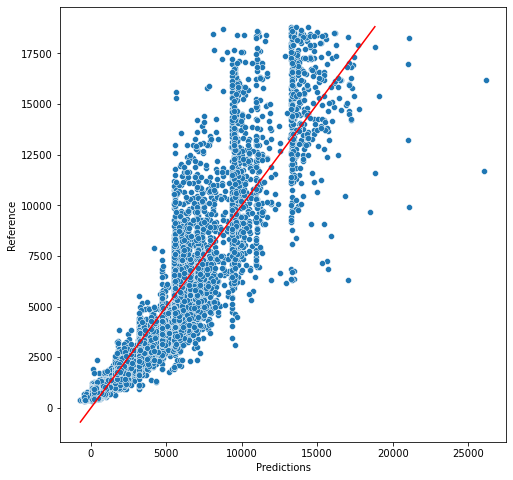

In [10]:
plot_predictions(results.true_values, results.predictions)

* Mean Squared Error (MSE): is calculated as the mean or average of the squared differences between predicted and expected target values.
$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_{i} - y_{e})^{2}$$

In [11]:
mse_pre = (results
               .assign(diff = lambda x: (x.true_values - x.predictions)**2)
               .agg({'diff':{'sum','count'}}))
mse = mse_pre.loc['sum'] / mse_pre.loc['count']
mse

diff    2.367452e+06
dtype: float64

In [12]:
# check our results with sklearn metrics
mod_res = {}
mod_res['1st_iter'] = {}
from sklearn.metrics import mean_squared_error
mod_res['1st_iter']['mse'] = mean_squared_error(results.true_values, results.predictions)
mod_res['1st_iter']['mse']

2367452.017766161

* Root Mean Squared Error (RMSE): 
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_{i} - y_{e})^{2}}$$

In [13]:
rmse = (mse_pre.loc['sum'] / mse_pre.loc['count'])**0.5
rmse

diff    1538.652663
dtype: float64

In [14]:
# check our results with sklearn metrics
mod_res['1st_iter']['rmse'] = mean_squared_error(results.true_values, results.predictions)**0.5
mod_res['1st_iter']['rmse']

1538.6526631329634

* Mean Absolute Error (MAE)
$$MAE = \frac{1}{n}\sum_{i=1}^{n} |y_{i} - y_{e}|$$

In [15]:
mae_pre = (results
               .assign(diff = lambda x: abs(x.true_values - x.predictions))
               .agg({'diff':{'sum','count'}}))
mod_res['1st_iter']['mae'] = mae_pre.loc['sum'] / mae_pre.loc['count']
mod_res['1st_iter']['mae']

diff    1010.730354
dtype: float64

In [16]:
# check our results with sklearn metrics
from sklearn.metrics import mean_absolute_error
mod_res['1st_iter']['mae'] = mean_absolute_error(results.true_values, results.predictions)
mod_res['1st_iter']['mae']

1010.730353672056

* Mean Absolute Percentage Error (MAPE)

$$MAPE = \frac{1}{n}\sum_{i=1}^{n} |\frac{y_{i} - y_{e}}{y_{i}}|$$

In [17]:
# Given that MAPE (mean absolute percentage error) doesn't exist in this version of sklearn, let's write a function:
def mean_abs_perc_error(y_true, y_pred):
    results = pd.DataFrame({
        'predictions':y_pred,
        'true_values':y_true
    })
    mape_pre = (results
               .assign(diff = lambda x: abs(x.true_values - x.predictions)/x.true_values)
               .agg({'diff':{'sum','count'}}))
    mape = mape_pre.loc['sum'] / mape_pre.loc['count']
    return mape.values[0]

# from sklearn.metrics import mean_absolute_percentage_error
mod_res['1st_iter']['mape'] = mean_abs_perc_error(results['true_values'], results['predictions'])
mod_res['1st_iter']['mape']
mod_res

{'1st_iter': {'mse': 2367452.017766161,
  'rmse': 1538.6526631329634,
  'mae': 1010.730353672056,
  'mape': 0.38396468307089227}}


        MSE: 2367452.017766161
        RMSE: 1538.6526631329634
        MAE: 1010.730353672056
        MAPE: 0.38396468307089227
        
18818 340


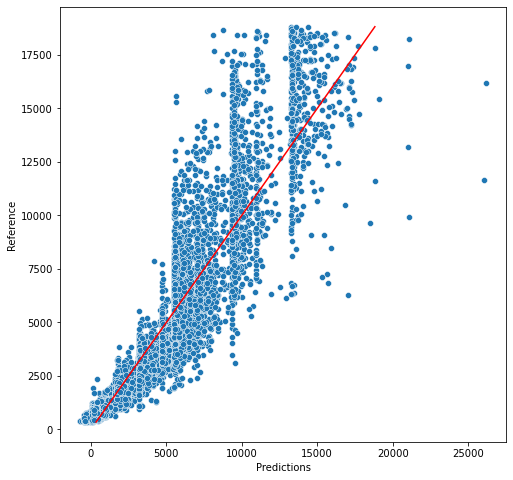

In [18]:
def plot_predictions(y_true, y_pred): 
    print(
        f"""
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        MAPE: {mean_abs_perc_error(y_true, y_pred)}
        """
    )
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.show()

    return {
        'mse': mean_squared_error(y_true, y_pred), 
        'rmse': mean_squared_error(y_true, y_pred)**0.5,
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_abs_perc_error(y_true, y_pred)
    }

mod_res['1st_iter'] = plot_predictions(y_test, results['predictions'])

Have this errors a normal distribution?

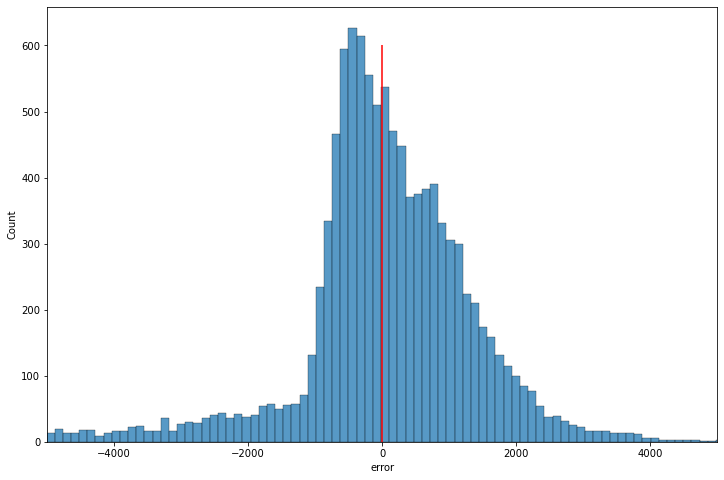

In [19]:
p_df = results.assign(error = lambda x: x['predictions'] - x['true_values'])

plt.subplots(figsize=(12, 8))
sns.histplot(p_df['error'])
plt.vlines(x=0, ymin=0, ymax=600, color='red')
# big problems with outliers
plt.xlim(-5000, 5000)
plt.show()
# skewness to the right, my model tend to predict a higer price then it should be

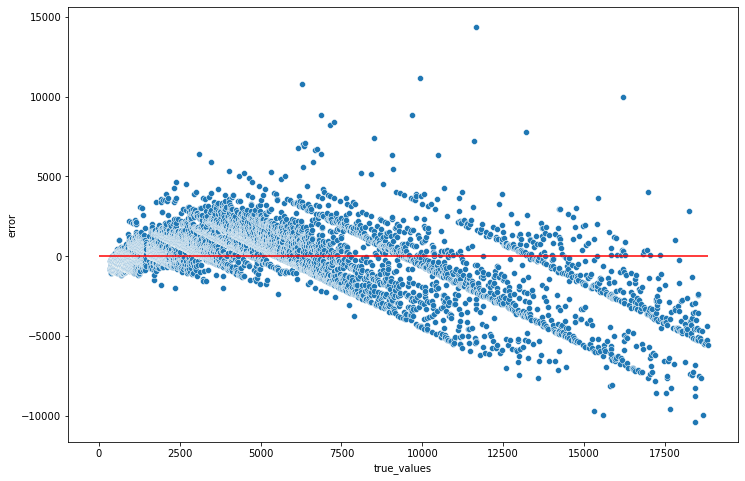

In [20]:
# another way to visualise our errors
p_df = p_df.sort_values(by='true_values')

plt.subplots(figsize=(12, 8))
sns.scatterplot(data=p_df, x='true_values', y='error')
plt.hlines(y=0, xmin=0, xmax=max(p_df['true_values']), color='red')
plt.show()

We can also detect that our model tend to predict worse as the diamonds get more expensive. Maybe we are missing some kind of qualities there. 

## 2nd iteration: Sklearn pipeline + all features

In [21]:
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
34530,0.33,Ideal,G,VVS1,62.0,56.0,4.45,4.48,2.77
26173,2.00,Very Good,I,VS2,59.5,62.0,8.13,8.21,4.86
20038,0.30,Good,H,SI1,63.4,58.0,4.21,4.24,2.68
41661,0.54,Ideal,J,VVS1,62.2,54.0,5.23,5.25,3.26
42306,0.41,Premium,D,VVS2,62.5,58.0,4.72,4.75,2.96


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

cat_pipeline = Pipeline(steps=[
    ('one_hot_enc', OneHotEncoder(drop='first'))
])
num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])

cat_cols = X_train.select_dtypes('category').columns.tolist()
num_cols = X_train.select_dtypes('float').columns.tolist()
full_processor = ColumnTransformer(transformers=[
    ('number', num_pipeline, num_cols), 
    ('category', cat_pipeline, cat_cols)
])

lm_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', LinearRegression())
])

_ = lm_pipeline.fit(X_train, y_train)
lm_pipeline

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('category',
                                                  Pipeline(steps=[('one_hot_enc',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('model', LinearRegression())])


        MSE: 1283144.2931933983
        RMSE: 1132.759591967068
        MAE: 741.8638658324736
        MAPE: 0.39243096397474125
        
18823 326


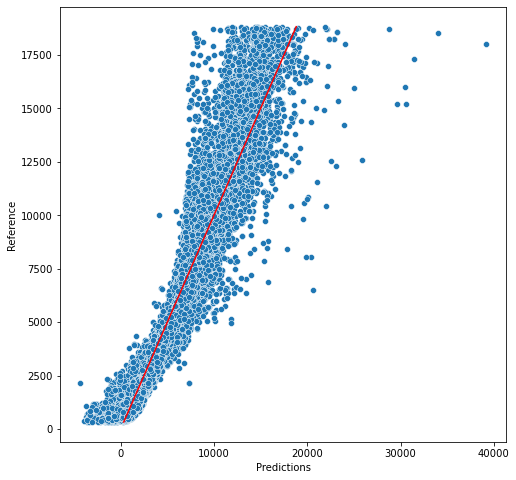

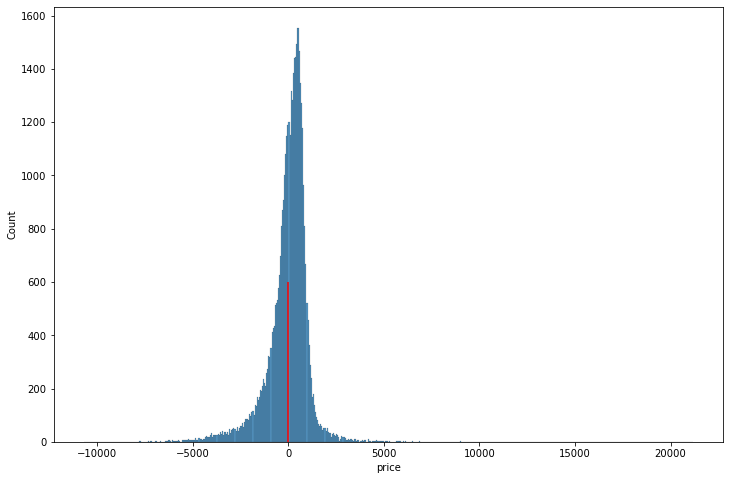

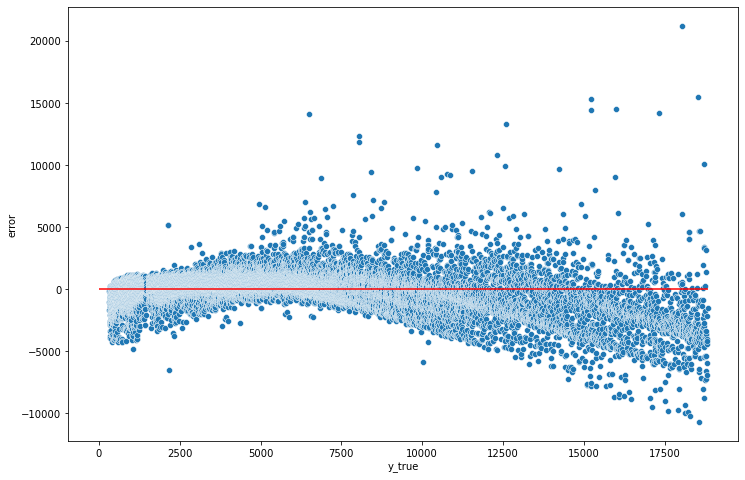

In [23]:
def plot_predictions(y_true, y_pred): 
    print(
        f"""
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        MAPE: {mean_abs_perc_error(y_true, y_pred)}
        """
    )
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Reference')
    plt.xlabel('Predictions')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    errors = y_pred - y_true
    plt.subplots(figsize=(12, 8))
    sns.histplot(errors)
    plt.vlines(x=0, ymin=0, ymax=600, color='red')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    p_df = (
        pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
        .assign(error = lambda x: x['y_pred'] - x['y_true'])
        .sort_values(by='y_true')
        )

    plt.subplots(figsize=(12, 8))
    sns.scatterplot(data=p_df, x='y_true', y='error')
    plt.hlines(y=0, xmin=0, xmax=max(p_df['y_true']), color='red')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    return {
        'mse': mean_squared_error(y_true, y_pred), 
        'rmse': mean_squared_error(y_true, y_pred)**0.5,
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_abs_perc_error(y_true, y_pred)

    }

    

# plot_predictions(y_test, results['predictions'])

mod_res['2nd_iter'] = plot_predictions(y_train, lm_pipeline.predict(X_train))

## 3rd iteration: Logirithm tranformation

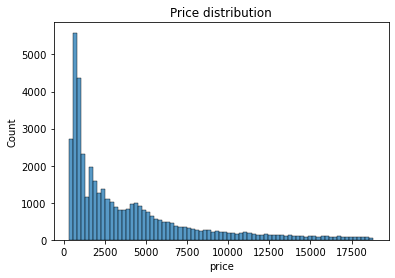

In [24]:
sns.histplot(y_train)
plt.title('Price distribution')
plt.show()

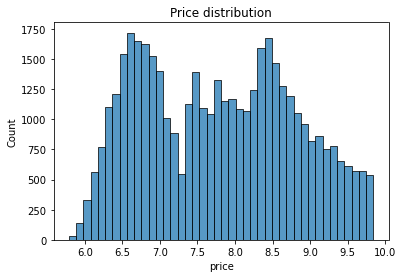

In [25]:
sns.histplot(np.log(y_train))
plt.title('Price distribution')
plt.show()


        MSE: 1262932.7438214659
        RMSE: 1123.8028046865988
        MAE: 485.84791717288965
        MAPE: 0.11358725361610643
        
18823 326


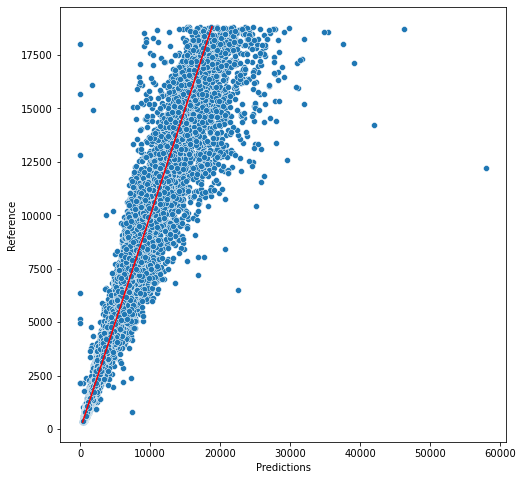

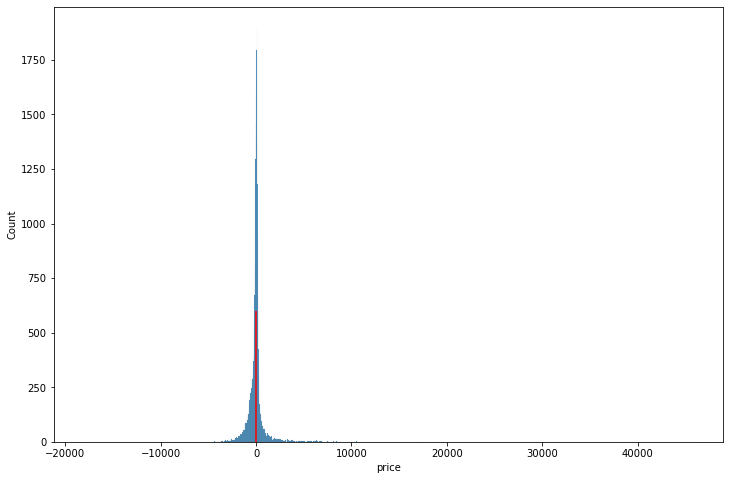

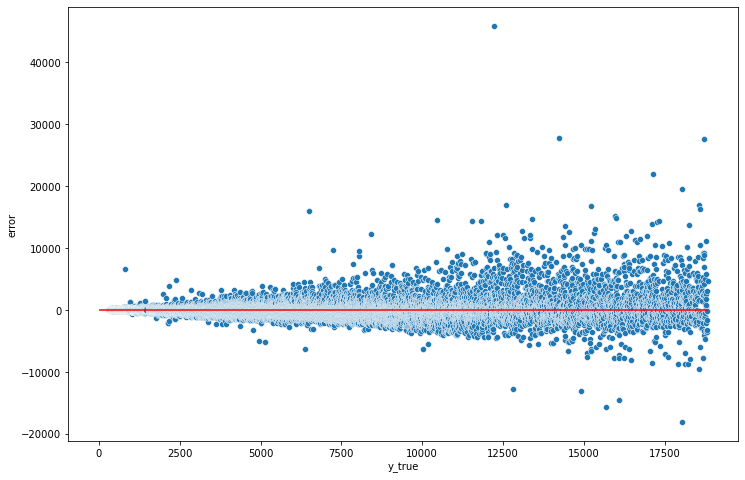

In [26]:
lm_pipeline.fit(X_train, np.log(y_train))
mod_res['3rd_iter'] = plot_predictions(y_train, np.exp(lm_pipeline.predict(X_train)))

## 4th iteration: exploring correlation


### Correlation Coeficient (Pearson)
![](../docs/pearson-coeficient.png)

### Examples

![](https://upload.wikimedia.org/wikipedia/commons/8/83/Pearson_Correlation_Coefficient_and_associated_scatterplots.png)

More information on wikipedia [link](https://en.wikipedia.org/wiki/Correlation)

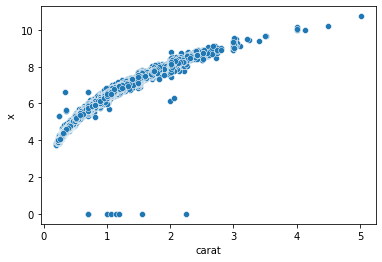

In [27]:
sns.scatterplot(data=X_train, x="carat", y="x")
plt.show()

In [28]:
import numpy as np

X_train_copy = X_train.copy()

X_train_copy['corrn'] = (
    (X_train_copy['carat'] - np.mean(X_train_copy['carat'])) * 
    (X_train_copy['x'] - np.mean(X_train_copy['x']))
)
X_train_copy.head()

X_train_copy['corr1'] = (X_train_copy['carat'] - np.mean(X_train_copy['carat']))**2
X_train_copy.head()

X_train_copy['corr2'] = (X_train_copy['x'] - np.mean(X_train_copy['x']))**2
X_train_copy.head()

corrn = sum(X_train_copy['corrn'])/np.sqrt(sum(X_train_copy['corr1']) * sum(X_train_copy['corr2']))
corrn

0.9743070067185388

In [29]:
# 1. function that given two columns, it returns the corr. coeficient
def corr_coeff(df, var1, var2): 
    temp = df.copy()
    temp['corrn'] = (
        (temp[var1] - np.mean(temp[var1])) * 
        (temp[var2] - np.mean(temp[var2]))
    )
    temp['corr1'] = (temp[var1] - np.mean(temp[var1]))**2
    temp['corr2'] = (temp[var2] - np.mean(temp[var2]))**2
    corrn = sum(temp['corrn'])/np.sqrt(sum(temp['corr1']) * sum(temp['corr2']))
    return corrn


# 2. Calculate the corr_coeficients for all the columns
temp = pd.concat([X_train, y_train], axis=1)

print(corr_coeff(temp, 'carat', 'z'))
print(corr_coeff(temp, 'price', 'x'))
print(corr_coeff(temp, 'price', 'carat'))



0.9490934369872173
0.8833442967899102
0.9210992431287798


In [30]:
num_cols = X_train.select_dtypes('float').columns
results = []
for col in num_cols:
    res2 = {}
    for col2 in num_cols:
        r = corr_coeff(X_train, col, col2)
        print(f'r between {col} and {col2} is {r}')
        res2[col2] = r
    results.append(res2)
dfr = pd.DataFrame(pd.json_normalize(results))
dfr.index = num_cols

dfr.head()

r between carat and carat is 1.0
r between carat and depth is 0.02869014807953855
r between carat and table is 0.18450269944791126
r between carat and x is 0.9743070067185388
r between carat and y is 0.9455576131382282
r between carat and z is 0.9490934369872173
r between depth and carat is 0.02869014807953855
r between depth and depth is 1.0
r between depth and table is -0.2975250147896719
r between depth and x is -0.02511872128145794
r between depth and y is -0.0294469010835403
r between depth and z is 0.09450033048363797
r between table and carat is 0.18450269944791126
r between table and depth is -0.2975250147896719
r between table and table is 1.0
r between table and x is 0.19752656889719242
r between table and y is 0.1847276642465391
r between table and z is 0.15254698130039962
r between x and carat is 0.9743070067185388
r between x and depth is -0.02511872128145794
r between x and table is 0.19752656889719242
r between x and x is 1.0
r between x and y is 0.968922725766768
r betw

,carat,depth,table,x,y,z
carat,1.000000,0.028690,0.184503,0.974307,0.945558,0.949093
depth,0.028690,1.000000,-0.297525,-0.025119,-0.029447,0.094500
table,0.184503,-0.297525,1.000000,0.197527,0.184728,0.152547
x,0.974307,-0.025119,0.197527,1.000000,0.968923,0.967107
y,0.945558,-0.029447,0.184728,0.968923,1.000000,0.943991


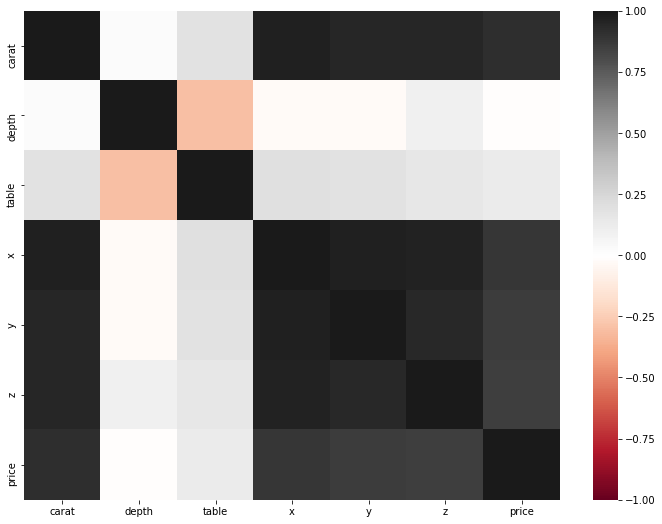

In [31]:
train = pd.concat([X_train, y_train], axis=1)
plt.subplots(figsize=(12, 9))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdGy')
plt.show()

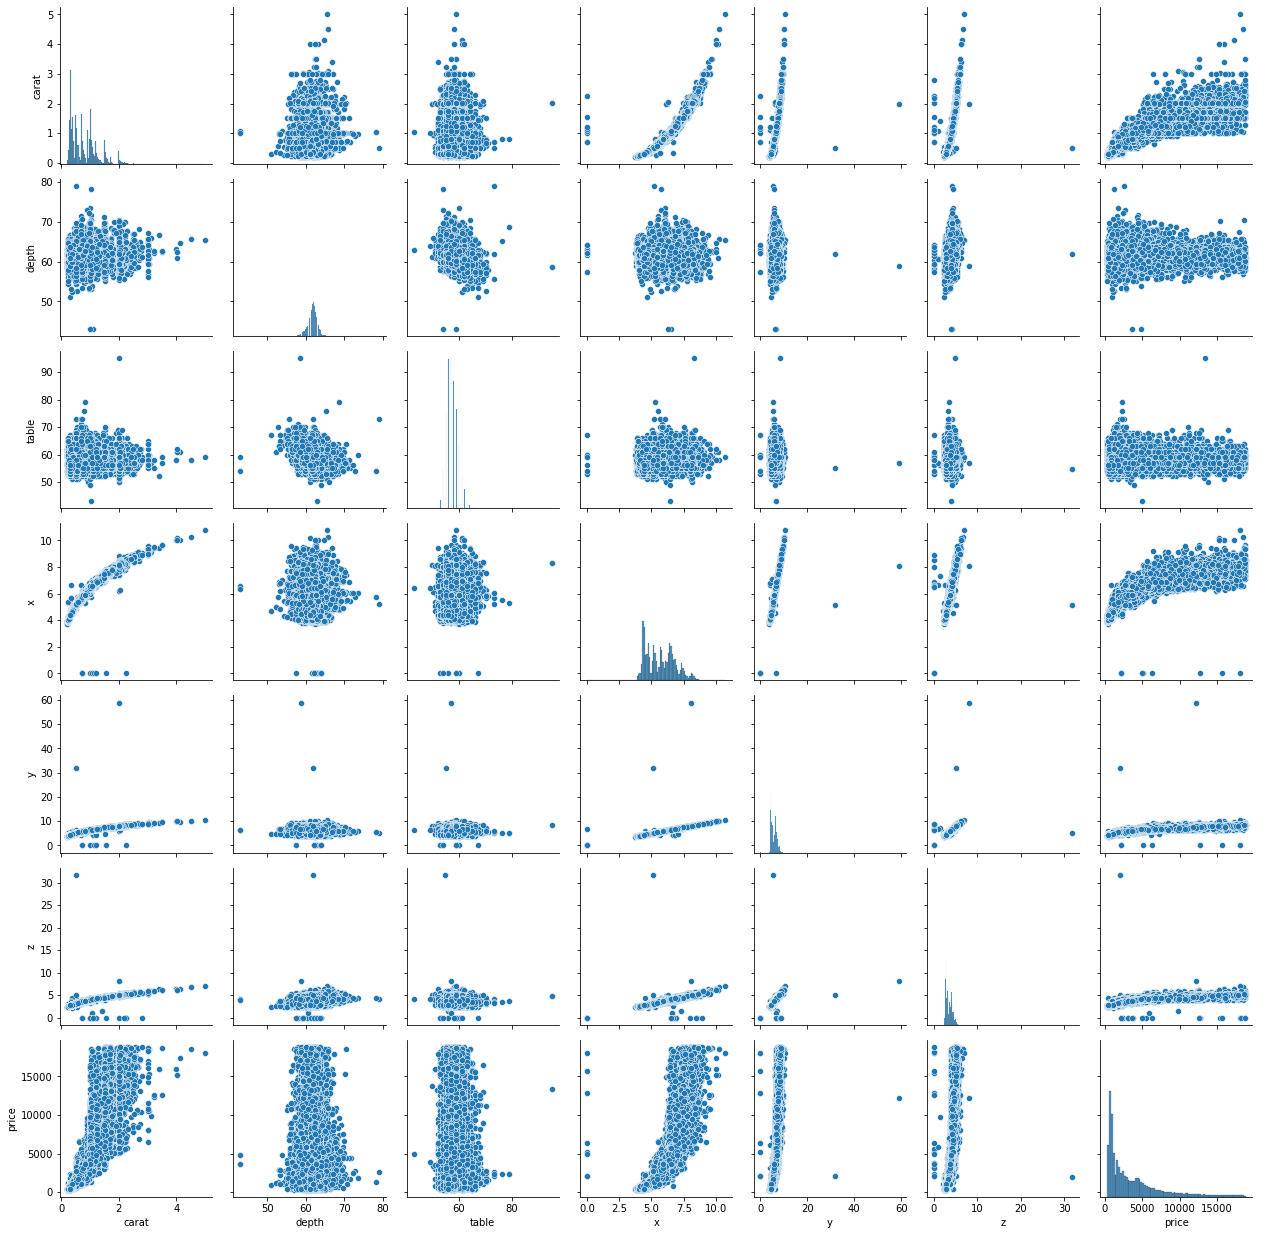

In [32]:
g = sns.PairGrid(train)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

### Problems 

1. [Correlation do not mean causality!](https://www.tylervigen.com/spurious-correlations)
2. Correlation only shows as a linear relation!

![](https://www.researchgate.net/profile/Graeme-Hickey/publication/276360680/figure/fig1/AS:324886896627716@1454470480110/Scatterplots-of-four-different-datasets-known-as-Anscombes-quartet-99-Each-dataset.png)

## 5th iteration: ordinal encoder

In [33]:
X = diamonds.drop(columns=['price'])
y = diamonds['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)

X_train.head()

from sklearn.preprocessing import OrdinalEncoder
cut = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color = ['D','E','F','G','H','I','J']
clarity = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

cat_pipeline = Pipeline(steps=[
    ('ord_enc', OrdinalEncoder(categories=[cut, color, clarity]))
])
num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])

cat_cols = X_train.select_dtypes('category').columns.tolist()
num_cols = X_train.select_dtypes('float').columns.tolist()
encoding = ColumnTransformer(transformers=[
    ('category', cat_pipeline, cat_cols),
    ('number', "passthrough", num_cols) 
])

lm_pipeline = Pipeline(steps=[
    ('encoding', encoding), 
    ('scale', MinMaxScaler()),
    ('model', LinearRegression())
])

_ = lm_pipeline.fit(X_train, np.log(y_train))


        MSE: 1565944.0297344152
        RMSE: 1251.376853603428
        MAE: 551.8877601222058
        MAPE: 0.12448058351926027
        
18818 340


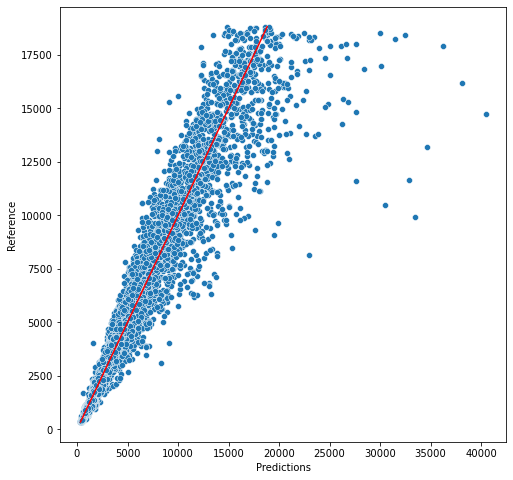

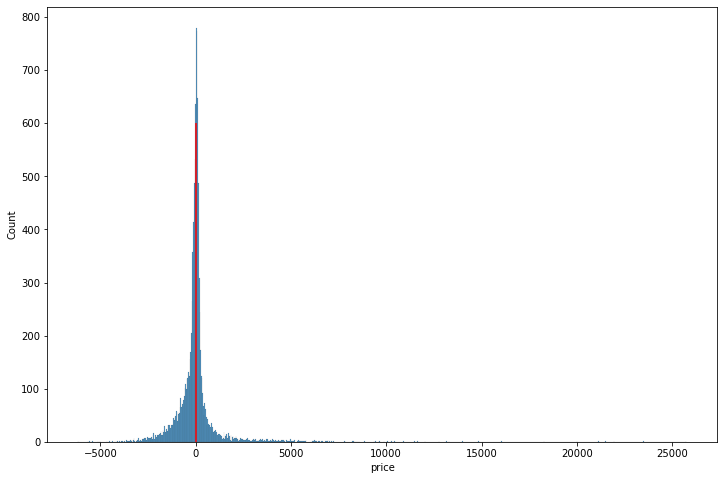

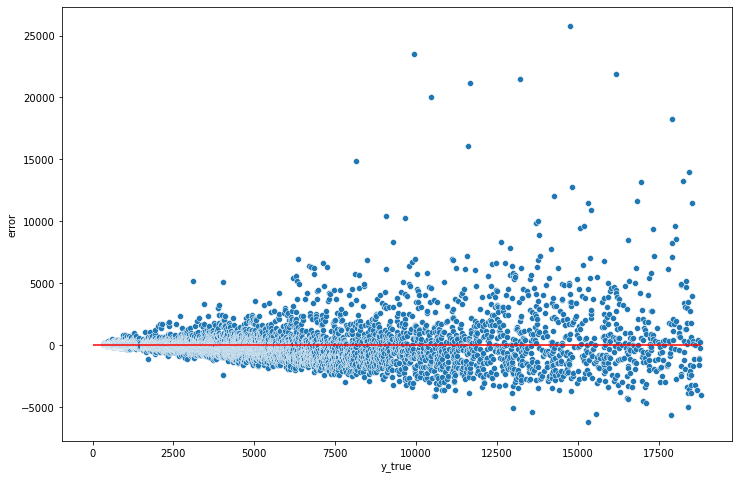

In [34]:
y_preds = np.exp(lm_pipeline.predict(X_test))
mod_res['4th_iter'] = plot_predictions(y_test, y_preds)

## 6th iteration: outliers

KeyError: 'LotArea'

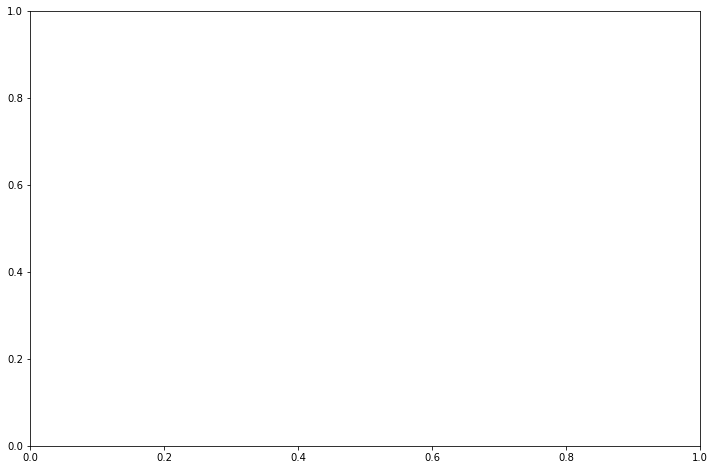

In [35]:
plt.subplots(figsize=(12, 8))
sns.scatterplot(x=X_train['LotArea'], y=y_train)
plt.axvline(x = 2.5, ymin=0, ymax=18000, c='red')
plt.show()


        MSE: 4411387.74600562
        RMSE: 2100.330389725774
        MAE: 732.2081357862467
        MAPE: 0.13852327479686358
        
18818 340


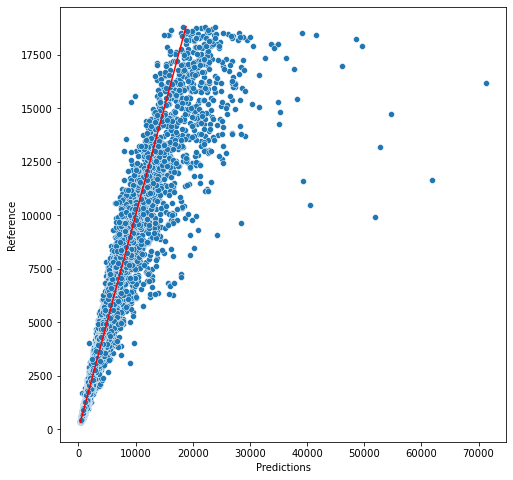

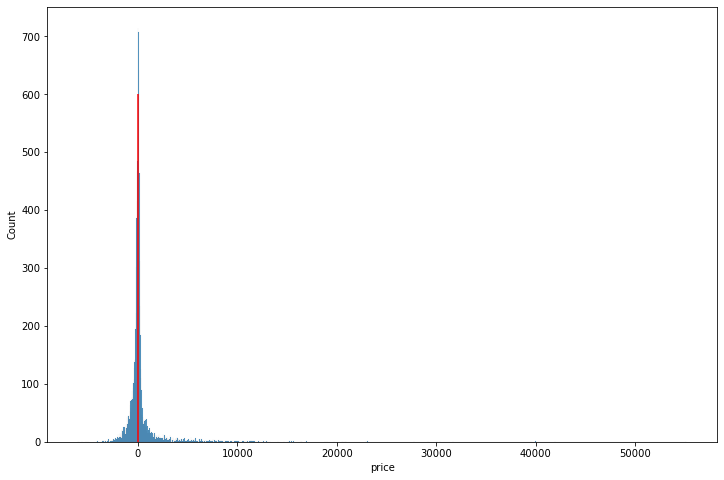

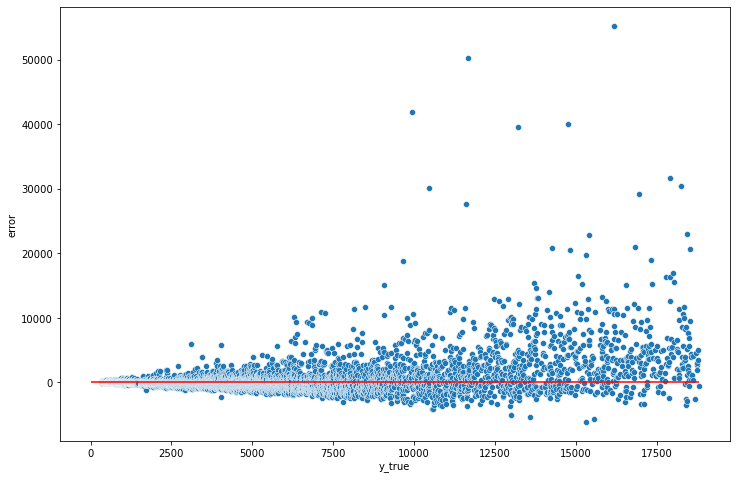

In [36]:
X_filt = (
pd.concat([X_train, y_train], axis=1)
    .query("carat < 2")
)
X_train_filt = X_filt.drop(columns='price')
y_train_filt = X_filt['price']
_ = lm_pipeline.fit(X_train_filt, np.log(y_train_filt))
y_pred = np.exp(lm_pipeline.predict(X_test))

mod_res['5th_iter'] = plot_predictions(y_test, y_pred)

## 7th iteration: model selection

--------------------
LinearRegression()

        MSE: 1565944.0297344152
        RMSE: 1251.376853603428
        MAE: 551.8877601222058
        MAPE: 0.12448058351926027
        
18818 340


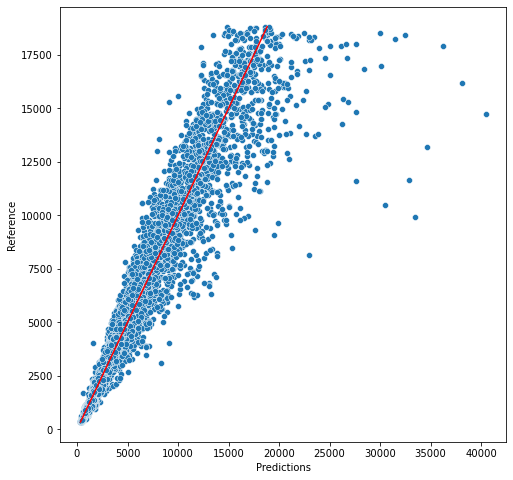

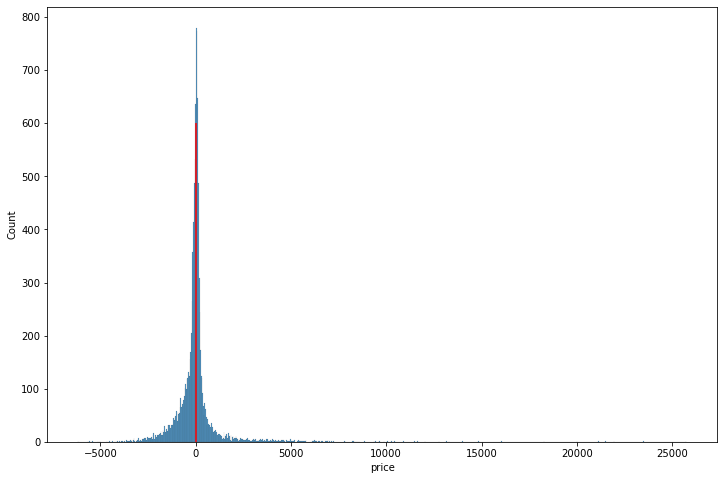

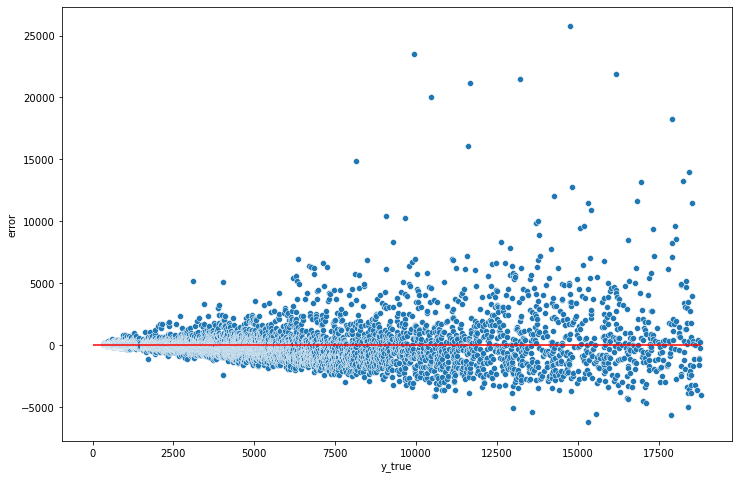

--- 0.917747974395752 seconds ---
--------------------
RandomForestRegressor()

        MSE: 301322.94728950167
        RMSE: 548.9289091398828
        MAE: 272.83147913484805
        MAPE: 0.06351748191683473
        
18186.042576037085 361.30731985125703


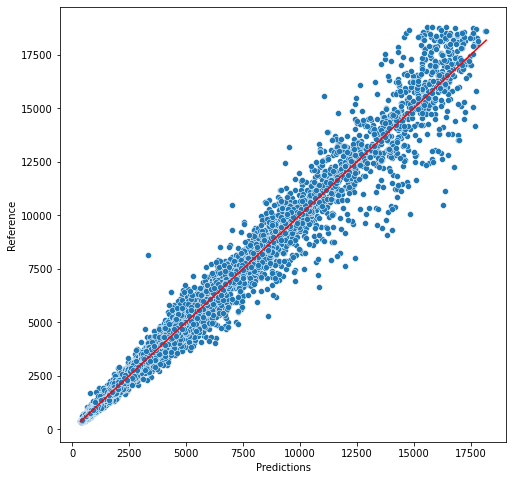

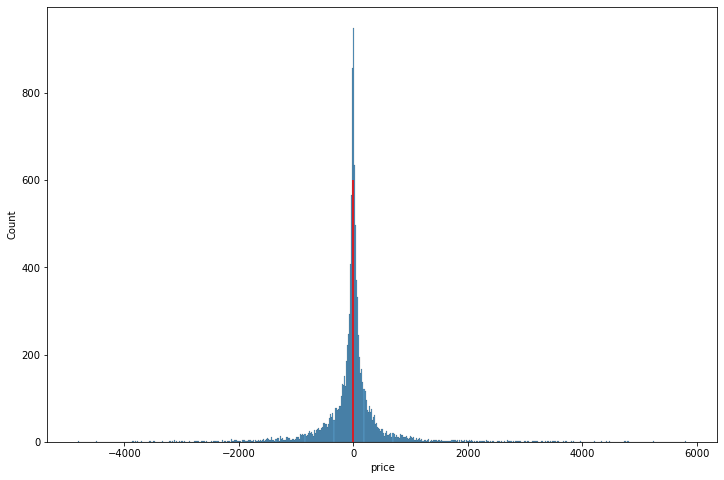

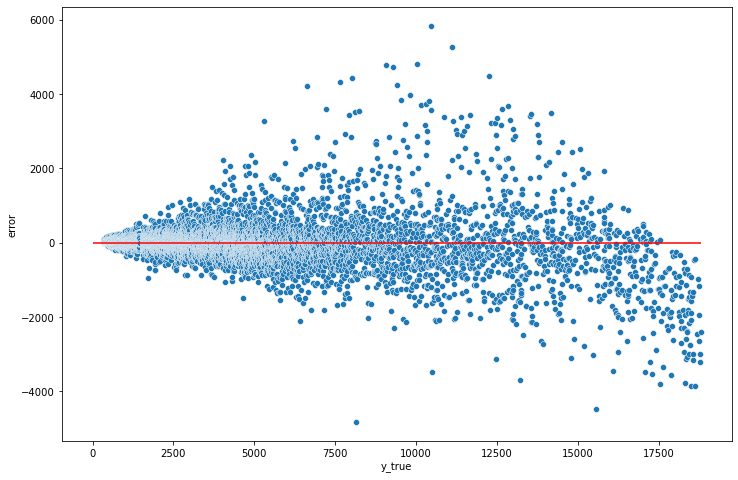

--- 12.526189088821411 seconds ---
--------------------
KNeighborsRegressor()

        MSE: 556369.4620341548
        RMSE: 745.9017777389694
        MAE: 375.33542029219944
        MAPE: 0.10022080262269333
        
18253.82436383762 369.35616553415423


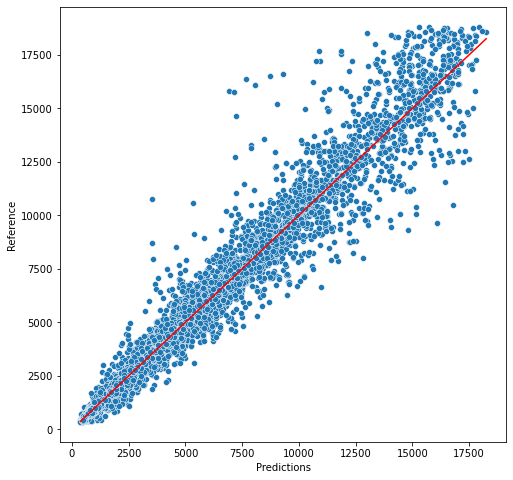

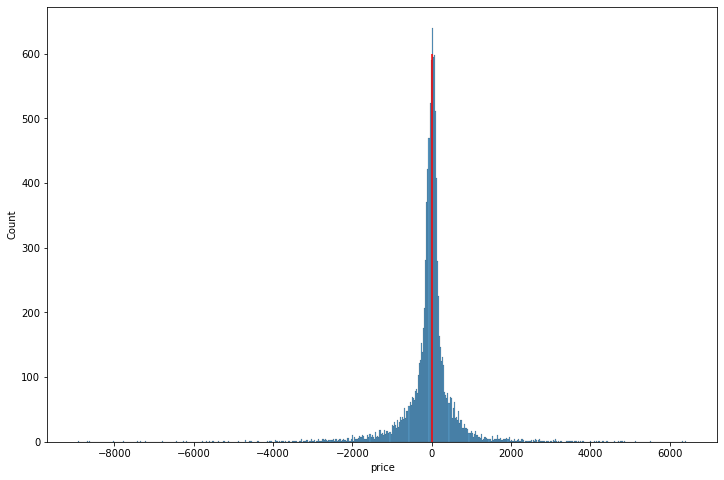

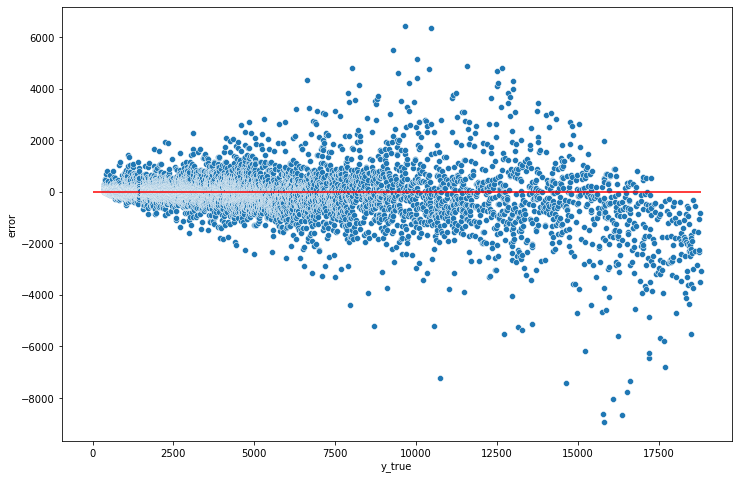

--- 1.0425219535827637 seconds ---
--------------------
SVR()

        MSE: 414657.7984471825
        RMSE: 643.939281646323
        MAE: 341.43937879326467
        MAPE: 0.08971534367899327
        
18818 340


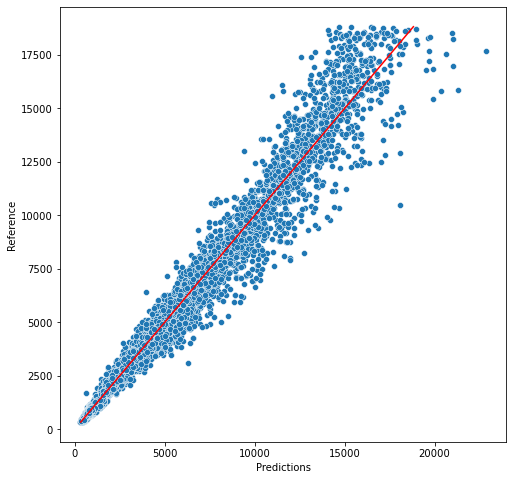

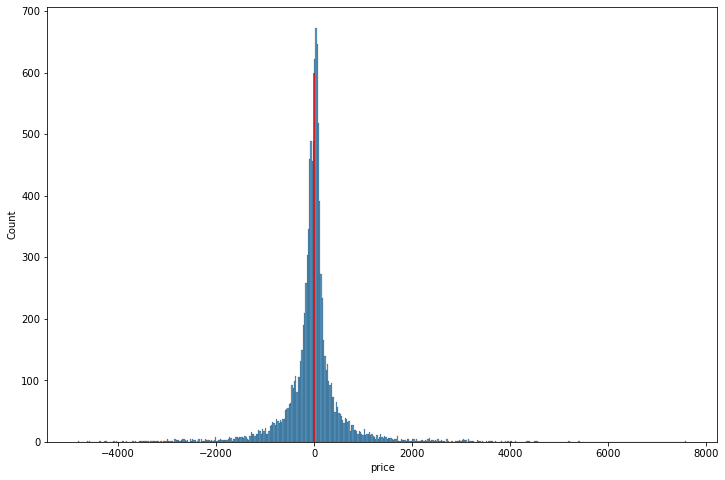

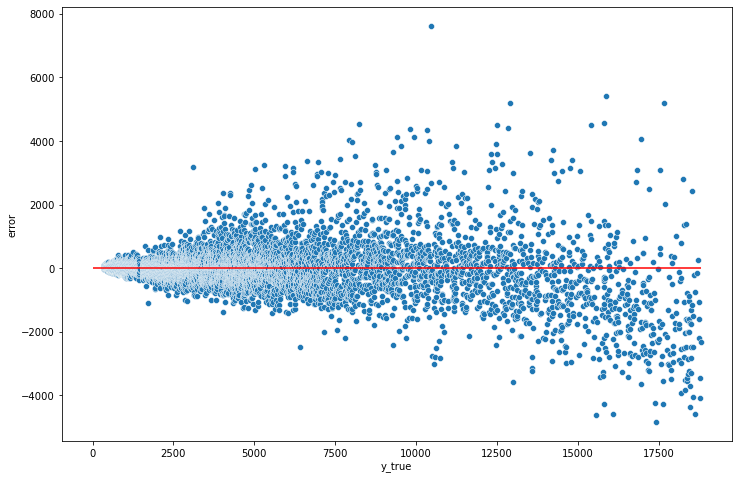

--- 70.98303008079529 seconds ---


In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import time

for model in [LinearRegression(), RandomForestRegressor(), KNeighborsRegressor(), SVR()]: 
    print('-'*20)
    print(model)
    start_time = time.time()
    lm_pipeline = Pipeline(steps=[
        ('encoding', encoding), 
        ('scale', MinMaxScaler()),
        ('model', model)
    ])
    _ = lm_pipeline.fit(X_train, np.log(y_train))
    y_pred = np.exp(lm_pipeline.predict(X_test))
    _ = plot_predictions(y_test, y_pred)
    print("--- %s seconds ---" % (time.time() - start_time), sep='/n')

    